# Nonreciprocity in the system of two transmons

Computing nonreciprocity in the system of two superconducting qubits (transmons).

Conventional approach with TLS.

In [1020]:
import qutip as qt
import numpy as np
import qucat as qc
import matplotlib.pyplot as plt

 ## System parameters

In [1197]:
N_excitations = 2
N_qubits = 2
DIM = N_excitations**N_qubits
NMAX = 50
DIRECTION = 'R'

# Asymmetry and decay
delta = 1e-1
gamma = 1e-2
gamma_nr = 2e-3*gamma
gamma_phi = 2e-3*gamma

# Field parameters
w_ext = 1.0
a_mag = 1e-2
if DIRECTION == 'R':
    a_R = a_mag
    a_L = 0e-2
elif DIRECTION == 'L':
    a_R = 0e-2
    a_L = a_mag
a_inc = {'R': a_R, 'L': a_L}

# Phase shifts
t_j = np.array([0.0, (np.pi - delta) / w_ext])
t_ij = np.array([[t_j[i] - t_j[j] for j in range(N_qubits)] for i in range(N_qubits)])

# Qubit parameters
w_q = np.array([w_ext, w_ext - delta*gamma])
gammas = np.array([gamma for j in range(N_qubits)])
deltas = np.array([w_q[j] - w_ext for j in range(N_qubits)])
Omega_R = np.array([1.0j*np.sqrt(0.5*gammas[j])*
                  (a_inc['R'] * np.exp(-1j * w_ext * t_j[j]) + 
                   a_inc['L'] * np.exp(1j * w_ext * t_j[j])) 
                  for j in range(N_qubits)])
Omega = np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                   np.sin(w_ext * np.abs(t_ij[i,j]))
                   for j in range(N_qubits)] 
                  for i in range(N_qubits)])
Gamma = np.array([[0.5*np.sqrt(gammas[i]*gammas[j])*
                   np.cos(w_ext * np.abs(t_ij[i,j]))
                   for j in range(N_qubits)] 
                  for i in range(N_qubits)])

## Defining states and operators

In [1198]:
# intial state
psi0 = qt.basis(N_excitations, 0) # start without excitations
for j in range(N_qubits - 1):
    psi0 = qt.tensor(psi0, qt.basis(N_excitations, 0))
rho0 = qt.ket2dm(psi0)

# transition operators
a_ops = [qt.destroy(N_excitations) if i==0 else qt.qeye(N_excitations) for i in range(N_qubits)]

for i in range(N_qubits):
    for j in range(1, N_qubits):
        if i==j:
            j_op = qt.destroy(N_excitations)
        else: 
            j_op = qt.qeye(N_excitations)
            
        a_ops[i] = qt.tensor(a_ops[i], j_op)
        
# unity operator        
i_op = qt.qeye(N_excitations)
for j in range(1, N_qubits):
    i_op = qt.tensor(i_op, qt.qeye(N_excitations))

# output operators
out_ops = {'R': a_inc['R']*i_op + sum([np.exp(-1j*w_q[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(N_qubits)]),
           'L': a_inc['L']*i_op + sum([np.exp(1j*w_q[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(N_qubits)])}

## Hamiltonian and Liouvillian

In [1199]:
def hamiltonian_tls(deltas, Omega_R, Omega):
    H_0 = sum([deltas[j]*a_ops[j].dag()*a_ops[j] for j in range(N_qubits)])
    H_f = sum([Omega_R[j]*a_ops[j] + np.conj(Omega_R[j])*a_ops[j].dag() for j in range(N_qubits)])
    H_d = sum(sum([[Omega[i,j]*a_ops[i].dag()*a_ops[j] for j in range(N_qubits)] for i in range(N_qubits)], []))
    return H_0 + H_f + H_d, H_0, H_f, H_d

In [1200]:
def transmission(direction: str, rho, a_inc):
    return qt.expect(out_ops[direction].dag()*out_ops[direction], 
                     rho) / np.abs(a_inc)**2

In [1201]:
def transmission_f(direction: str, rho, a_inc):
    return np.abs(qt.expect(out_ops[direction], rho)) / np.abs(a_inc)

In [1202]:
H, H_0, H_f, H_d  = hamiltonian_tls(deltas, Omega_R, Omega)
L_diss = sum([sum([2*Gamma[i,j]*qt.lindblad_dissipator(a_ops[i], a_ops[j]) 
                   for j in range(N_qubits)]) for i in range(N_qubits)])
c_ops_nr = [np.sqrt(gamma_nr) * a_ops[j] for j in range(len(a_ops))]
c_ops_deph = [np.sqrt(gamma_phi) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) for j in range(len(a_ops))]
L_0 = qt.liouvillian(H, c_ops=c_ops_nr + c_ops_deph)
L = L_0 + L_diss

## Time evolution

In [1203]:
# ODE solver options
opts = qt.Options(atol=1e-16, rtol=1e-14, method='adams', order=12, nsteps=10000, first_step=0, max_step=0, 
        min_step=0, average_expect=True, average_states=False, tidy=True, num_cpus=0, norm_tol=0.001, 
        norm_t_tol=1e-06, norm_steps=5, rhs_reuse=False, rhs_filename=None, ntraj=500, gui=False, 
        rhs_with_state=False, store_final_state=False, store_states=False, steady_state_average=False, 
        seeds=None, normalize_output=True, use_openmp=None, openmp_threads=None)


In [1204]:
tlist = np.linspace(0.0, 1e6, 200)
rho_ss = qt.steadystate(L, method='iterative-gmres', maxiter=1e9, tol=1e-24, use_precond=True)
result_t = qt.mesolve(L, rho0, tlist, c_ops=[], e_ops=[], options=qt.Options(nsteps=1e7))

In [1205]:
rho_ss

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 9.86146380e-01+0.00000000e+00j  5.17326763e-02-3.43913209e-03j
  -8.64130962e-02+1.63883913e-03j -9.49049435e-03+6.90723096e-04j]
 [ 5.17326763e-02+3.43913209e-03j  4.41908642e-03+0.00000000e+00j
  -2.84663039e-03-5.13484257e-05j -4.96962043e-04+2.54379470e-05j]
 [-8.64130962e-02-1.63883913e-03j -2.84663039e-03+5.13484257e-05j
   9.34023354e-03+0.00000000e+00j  8.45812273e-04-2.27748878e-05j]
 [-9.49049435e-03-6.90723096e-04j -4.96962043e-04-2.54379470e-05j
   8.45812273e-04+2.27748878e-05j  9.43003166e-05+0.00000000e+00j]]

In [1206]:
transmission(DIRECTION, rho_ss, a_inc[DIRECTION])

0.01633491637400923

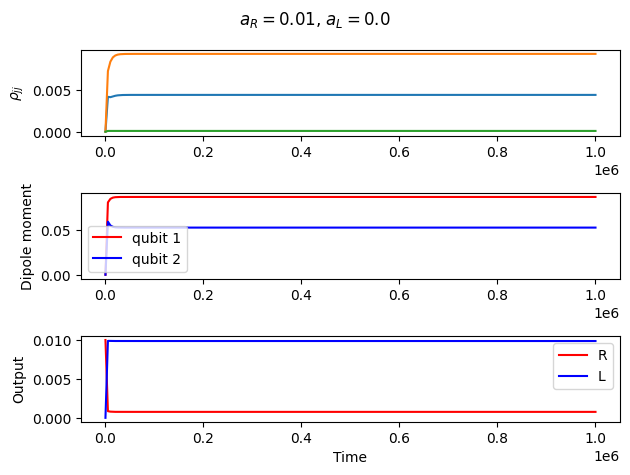

In [1207]:
fig_0, ax = plt.subplots(3, 1)
ax[0].plot(tlist, [result_t.states[i].diag()[1:DIM] for i in range(len(tlist))])
ax[0].set_ylabel(r'$\rho_{jj}$')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[0], result_t.states)), color='r', label='qubit 1')
ax[1].plot(tlist, np.abs(qt.expect(a_ops[1], result_t.states)), color='b', label='qubit 2')
ax[1].set_ylabel('Dipole moment')
ax[1].legend()
ax[2].plot(tlist, np.abs(qt.expect(out_ops['R'], result_t.states)), color='r', label='R')
ax[2].plot(tlist, np.abs(qt.expect(out_ops['L'], result_t.states)), color='b', label='L')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Output')
ax[2].legend()
fig_0.suptitle(r"$a_R = %s$, $a_L = %s$" % (a_inc['R'], a_inc['L']))
fig_0.tight_layout()

## Incident power dependence

In [1208]:
def transmission_power_dependence(a_inc, direction: str = 'R'):
    Omega_R = np.array([1.0j*np.sqrt(0.5*gammas[j])*
                  (a_inc * np.exp(- 1j * w_ext * t_j[j])
                   if direction == 'R' else
                   a_inc * np.exp(1j * w_ext * t_j[j]))
                  for j in range(N_qubits)])
    out_ops = {'R': a_inc*i_op + sum([np.exp(-1j*w_q[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(N_qubits)]),
               'L': a_inc*i_op + sum([np.exp(1j*w_q[j]*t_j[j])*
                                         np.sqrt(0.5*gammas[j])*a_ops[j] for j in range(N_qubits)])}
    
    H, _, _, _ = hamiltonian_tls(deltas, Omega_R, Omega)
    L_diss = sum([sum([2*Gamma[i,j]*qt.lindblad_dissipator(a_ops[i], a_ops[j]) 
                       for j in range(N_qubits)]) for i in range(N_qubits)])
    c_ops_nr = [np.sqrt(gamma_nr) * a_ops[j] for j in range(len(a_ops))]
    c_ops_deph = [np.sqrt(gamma_phi) * (a_ops[j].dag()*a_ops[j] - a_ops[j]*a_ops[j].dag()) for j in range(len(a_ops))]
    L_0 = qt.liouvillian(H, c_ops=c_ops_nr + c_ops_deph)
    L = L_0 + L_diss
    
    rho_ss = qt.steadystate(L, method='iterative-gmres', maxiter=1e9, tol=1e-24, use_precond=True)
    #(qt.expect(out_ops[direction].dag()*out_ops[direction], 
    #                 rho_ss) / np.abs(a_inc)**2)  # intensity transmission
    return (np.abs(qt.expect(out_ops[direction], rho_ss)) / np.abs(a_inc))  # field transmission

In [1209]:
transmission_power_dependence(10.1, direction='L')

0.999950873267721

In [1210]:
a_inc_list = 10.0**np.linspace(-6, 0, NMAX)  # field amplitudes

transmission_R = np.array(qt.parallel_map(transmission_power_dependence, 
                                 a_inc_list,  
                                 task_kwargs=dict(direction='R')))
transmission_L = np.array(qt.parallel_map(transmission_power_dependence, 
                                 a_inc_list,  
                                 task_kwargs=dict(direction='L')))
efficiency = (transmission_L*np.abs((transmission_L - transmission_R) /
                         (transmission_L + transmission_R)))

Text(0, 0.5, 'Transmission')

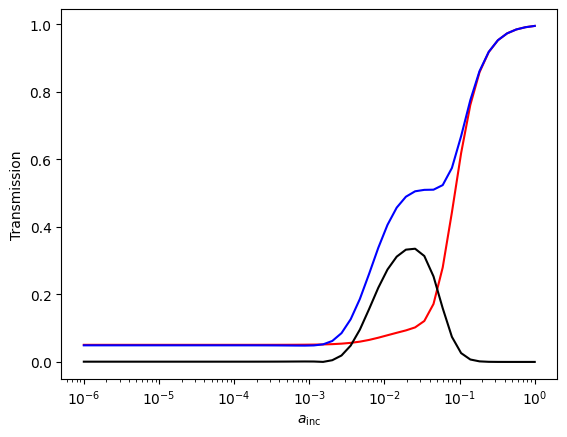

In [1211]:
fig_1, ax = plt.subplots(1, 1)

ax.plot(a_inc_list, transmission_R, color='r', label='R')
ax.plot(a_inc_list, transmission_L, color='b', label='L')
ax.plot(a_inc_list, efficiency, color='black', label='M')
ax.set_xscale('log')
ax.set_xlabel(r'$a_\mathrm{inc}$')
ax.set_ylabel('Transmission')